In [1]:
import pylab
import numpy as np
np.seterr(all='raise')
np.random.seed(13)
import scipy as sp
import pandas as pd # tablas de datos -> bases datos
import seaborn as sns; sns.set() # graficar (sobre matplotlib) ampliar la funcionalidad de matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('text', usetex=True)
%matplotlib inline
# from tqdm import tqdm

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

### Omitir por el momento

In [2]:
def calc_error(res,e,names=[]):
    tmp_i = np.zeros(len(res.x))
    etol = e * max(1, abs(res.fun))
    for i in range(len(res.x)):
        tmp_i[i] = 1.0
        hess_inv_i = res.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(etol * hess_inv_i)
        tmp_i[i] = 0.0
        if len(names) > 0:
            print('{0} = {1:12.4e} ± {2:.1e}'.format(names[i], res.x[i], uncertainty_i))
        else:
            print('x^{0} = {1:12.4e} ± {2:.1e}'.format(i, res.x[i], uncertainty_i))

# Revisar bases de datos conocidas
[SciKit Learn](https://scikit-learn.org/stable/datasets/index.html)
<!-- X,Y = datasets.load_boston(return_X_y=True) -->

In [13]:
A = pd.DataFrame(housing['data'], columns=housing['feature_names'])
b = pd.DataFrame(housing['target'], columns=["MEDV"])
A.insert(0,'c0',1)
 # -36.9419202
 # -3.69419202 -> numerico de precision

In [14]:
A

,c0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,10,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,10,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,10,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,10,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,10,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,10,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,10,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,10,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,10,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


$$\mathbb{A}\cdot\vec{x} + c_0 \cdot \mathbb{1} = \vec{b} $$

Tenemos que utilizar minimimos cuadrados?

$$MSE=\min_{\vec{x}} || \vec{b} - \mathbb{A}\cdot\vec{x} ||^2$$
La funcion de costo -> Cost function



$$\vec{x} = (\mathbb{A}^T\cdot\mathbb{A})^{-1}\cdot\mathbb{A}^T\vec{b} $$

y = rho()*sigma_y/sigma_x

$$X = x_1+x_2+x_3+\dots$$
Mi intención,
$$CRIM\times x_1+ZN\times x_2+INDUS\times x_3+\dots = b$$

In [15]:
Anumpy = np.matrix(A.to_numpy(dtype=np.float64)) # ""
bnumpy = np.matrix(b.to_numpy(dtype=np.float64))

In [16]:
# %%timeit
X_opt = np.linalg.inv(Anumpy.T*Anumpy)*Anumpy.T*bnumpy

In [17]:
print(X_opt.T)

[[-3.69419202e+00  4.36693293e-01  9.43577803e-03 -1.07322041e-01
   6.45065694e-01 -3.97638942e-06 -3.78654266e-03 -4.21314378e-01
  -4.34513755e-01]]


In [74]:
np.array(Anumpy*X_opt).flatten()

array([4.128294  , 3.9739418 , 3.6751823 , ..., 0.16096497, 0.3091488 ,
       0.50494385], dtype=float32)

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


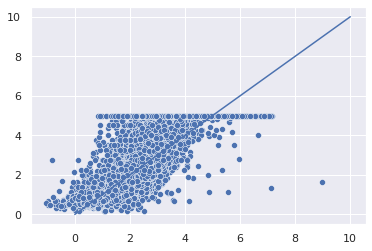

In [75]:
sns.scatterplot(np.array(Anumpy*X_opt).flatten(),np.array(bnumpy).flatten())
plt.plot([0,10],[0,10])

In [19]:
predicciones = np.array(Anumpy*X_opt).flatten()

In [20]:
observaciones = np.array(bnumpy).flatten()
bbarrita = observaciones.mean()

In [21]:
r2 = 1-(np.linalg.norm(predicciones - observaciones)**2)/(np.linalg.norm(observaciones - bbarrita)**2)

In [22]:
r2

0.606232685199805

# Implementemos nuestro algoritmo de Optimización por Newton Raphson
La idea es encontrar $X_{opt}$ de forma iterativa sin invertir la matriz

In [23]:
# Definamos la func de costo (debe devolver un escalar)
def L(x,A,b):
    # (b_pred-b_obs)^2
    # m es el numero de datos
    # n es el numero de parametros == 13
    m,n = A.shape
    X = np.matrix(x).T
    DeltaB=(A*X-b) # b gorro - b
    return (DeltaB.T*DeltaB)[0,0]/m # matriz 1x1
def dLdx(x,A,b): # gradiente de L
    # (b_pred-b_obs)^2
    # m es el numero de datos
    # n es el numero de parametros == 13
    m,n = A.shape
    X = np.matrix(x).T
    DeltaB=(A*X-b) 
    return (2/m)*np.array(A.T*DeltaB).flatten() # como un vector [1,2,3] y no como un "vector matriz" [[1],[2],[3]]

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

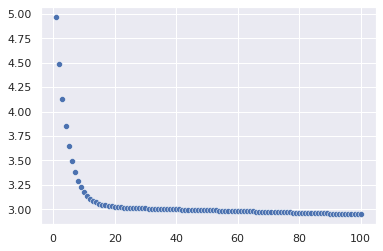

In [29]:
# encontrar una forma iterativa de actualizar X para ir minimizando la funcion de costo L
x = np.zeros(Anumpy.shape[1])
epsilon = 2e-8
cost = []
N = 100
for it in range(N):
    x = x - epsilon*dLdx(x,Anumpy,bnumpy)
    cost.append(L(x,Anumpy,bnumpy))
sns.scatterplot(np.arange(N)+1,cost)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
L(np.array(X_opt).flatten(),Anumpy,bnumpy)

In [30]:
np.array(X_opt).flatten()

array([-3.69419202e+00,  4.36693293e-01,  9.43577803e-03, -1.07322041e-01,
        6.45065694e-01, -3.97638942e-06, -3.78654266e-03, -4.21314378e-01,
       -4.34513755e-01])

In [41]:
# %%timeit
res1 = sp.optimize.minimize(fun=L,x0=np.zeros(Anumpy.shape[1]), args = (Anumpy,bnumpy), tol=1e-10)
res1['x']

array([-3.69654985e+00,  4.36636097e-01,  9.43067528e-03, -1.07266441e-01,
        6.44883308e-01, -4.01148248e-06, -3.78573753e-03, -4.21563194e-01,
       -4.34787715e-01])

In [31]:
e=1e-10

In [42]:
# %%timeit
res2 = sp.optimize.minimize(fun=L,jac=dLdx, x0=np.zeros(Anumpy.shape[1]), args = (Anumpy,bnumpy), method='Newton-CG', tol=e)
res2['x']

array([-3.69418858e+00,  4.36693422e-01,  9.43578439e-03, -1.07322153e-01,
        6.45066089e-01, -3.97637827e-06, -3.78654379e-03, -4.21314043e-01,
       -4.34513363e-01])

In [44]:
# %%timeit
res3 = sp.optimize.minimize(fun=L,jac=dLdx, x0=np.zeros(Anumpy.shape[1]), args = (Anumpy,bnumpy), method='L-BFGS-B', tol=e)
res3['x']

array([-3.69323935e+00,  4.36673964e-01,  9.43490165e-03, -1.07519232e-01,
        6.45856645e-01, -4.01725760e-06, -3.77680688e-03, -4.21318680e-01,
       -4.34438207e-01])

In [48]:
L(res1['x'],Anumpy,bnumpy)

0.524321020366028

In [46]:
L(res2.x,Anumpy,bnumpy)

0.5243209861846829

In [47]:
L(res3.x,Anumpy,bnumpy)

0.5243211095424838

In [49]:
L(np.array(X_opt).flatten(),Anumpy,bnumpy)

0.5243209861846072

In [52]:
calc_error(res3,e,names=[])

x^0 =  -3.6932e+00 ± 5.1e-02
x^1 =   4.3667e-01 ± 7.6e-04
x^2 =   9.4349e-03 ± 9.0e-05
x^3 =  -1.0752e-01 ± 4.0e-04
x^4 =   6.4586e-01 ± 3.9e-03
x^5 =  -4.0173e-06 ± 4.4e-07
x^6 =  -3.7768e-03 ± 1.8e-05
x^7 =  -4.2132e-01 ± 5.3e-03
x^8 =  -4.3444e-01 ± 5.9e-03


# Fit a funciones no lineales

In [3]:
print("Nuestra caja experimental!")
a = 3/2
b = 4
c = -3
N=100
x = np.linspace(0.2,10,N) # 0.2 y 10 en N elementos igualmente espaciados
y = a/(1+np.exp(c*(x-b))) # modelo teorico -> principio fisico, matematico, biologico...
x1 = x + np.random.exponential(0.01,size=N)
y1 = y + np.random.normal(0,0.05,size=N) # ruido gaussiano
x2 = x + np.random.normal(0,0.03,size=N)
y2 = y + np.random.exponential(0.05,size=N) # ruido exponencial

Nuestra caja experimental!


/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

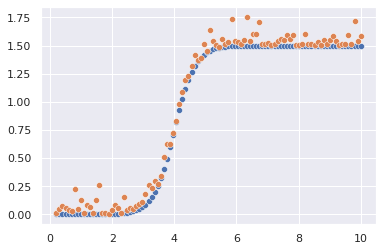

In [8]:
sns.scatterplot(x,y)
sns.scatterplot(x,y2)

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

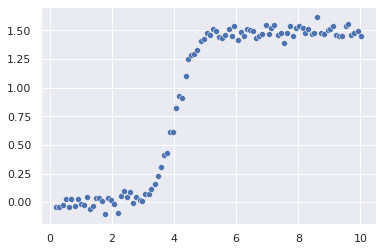

In [9]:
sns.scatterplot(x1,y1)

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

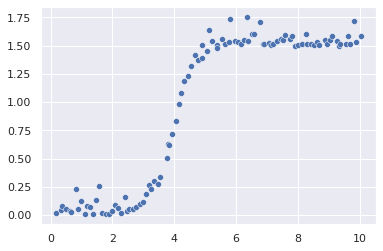

In [10]:
sns.scatterplot(x2,y2)

# ¿Cómo hacer el fit a la función?
$$f(x) = a\frac{1}{1+e^{b(x-c)}}$$

In [13]:
#como encuentro yo a, b y c?
# cual seria nuestra funcion de costo
def f(parametros,x): # parametros es un vector de 3 componentes
    return parametros[0]/(1+np.exp(parametros[1]*(x-parametros[2])))
def Lfit(parametros,x,y): # funcion de costo MSE (No es la mejor!)
    # L = promedio sobre todos los puntos (f(a,b,c;x)-y)^2
    # parametros np.array([a,b,c])
    deltaY=f(parametros,x) - y
    return np.dot(deltaY,deltaY)/len(y)

In [16]:
print("Ajuste para el primer set: x1,y1")
e=1e-8
# ansatz: a=1,b=0,c=0
res1 = sp.optimize.minimize(fun=Lfit, x0=np.array([1,0,0]), args = (x2,y2), method='L-BFGS-B', tol=e)
res1

Ajuste para el primer set: x1,y1


      fun: 0.0045339366525594844
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.29597462e-09,  2.08166818e-08, -6.49653946e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 128
      nit: 26
     njev: 32
   status: 0
  success: True
        x: array([ 1.55957949, -2.70944768,  3.95216171])

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


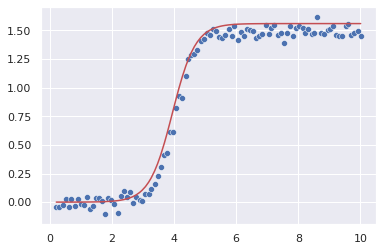

In [17]:
y1_pred = f(res1.x,x1)
sns.scatterplot(x1,y1)
plt.plot(x1,y1_pred,color='r')

In [18]:
r2 = 1-np.sum((y1_pred-y1)**2)/np.sum((y1-y1.mean())**2)
r2

0.9873960715672234

In [19]:
calc_error(res1,e,names=['a','b','c'])

a =   1.5596e+00 ± 1.1e-04
b =  -2.7094e+00 ± 7.4e-04
c =   3.9522e+00 ± 2.8e-04


# ¿Cómo hacer el fit a la función?
$$f(x) = a + b\tanh(c(x-d))$$

In [20]:
#como encuentro yo a, b y c?
# cual seria nuestra funcion de costo
def ftilde(parametros,x):
    return parametros[0]+parametros[1]*np.tanh(parametros[2]*(x-parametros[3]))
def Lfit(parametros,x,y):
    # L = promedio sobre todos los puntos (f(a,b,c,d;x)-y)^2
    # parametros np.array([a,b,c,d])
    deltaY=ftilde(parametros,x) - y
    return np.dot(deltaY,deltaY)/len(y)

In [21]:
print("Ajuste para el primer set: x1,y1")
e=1e-8
# ansatz: a=0,b=1,c=0,d=0
res1 = sp.optimize.minimize(fun=Lfit, x0=np.array([0,1,0,0]), args = (x1,y1), method='L-BFGS-B', tol=e)
res1

Ajuste para el primer set: x1,y1


      fun: 0.0017821404399037827
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.78686099e-06, -3.25134883e-06, -1.16898679e-07, -1.70625234e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 215
      nit: 35
     njev: 43
   status: 0
  success: True
        x: array([0.74355517, 0.74804463, 1.57053584, 4.02668731])

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


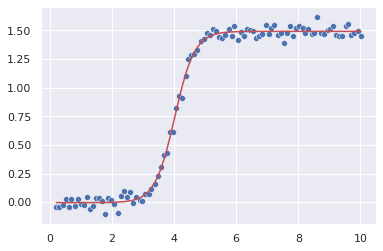

In [22]:
y1_pred = ftilde(res1.x,x1)
sns.scatterplot(x1,y1)
plt.plot(x1,y1_pred,color='r')

In [23]:
r2 = 1-np.sum((y1_pred-y1)**2)/np.sum((y1-y1.mean())**2)
r2

0.9961469840436844

In [25]:
calc_error(res1,e,names=['a','b','c','d'])

a =   7.4356e-01 ± 8.7e-05
b =   7.4804e-01 ± 9.5e-05
c =   1.5705e+00 ± 6.4e-04
d =   4.0267e+00 ± 3.1e-04
